# Distinguishing benign and malignant breast cancer tissues in breast cancer images using Convolutional Neural Network

Hong Chen, hc3028, Meng Ren, mr3847

***
<font color = "blue">

# Preparation
### 1. Import pakage and creat environment

In [14]:
# This cell contains all the libraries that we used in the execution of the project.
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow.contrib.eager as tfe
from matplotlib import pyplot as plt
from tensorflow import keras
import numpy as np
import random
# from datascience import *
import csv
from os.path import join
import os
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,Dropout,Activation,BatchNormalization,MaxPool2D,Flatten,Dense,ZeroPadding2D
from sklearn.model_selection import train_test_split
%matplotlib inline
from numpy import *
#import matplotlib.pyplot as plt
#import matplotlib.cbook as cbook
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
import random

tf.enable_eager_execution()

device = "gpu:0" if tfe.num_gpus() else "cpu:0"

***
<font color = "blue">

### 2. Load file path, plot bar chart to visualize different lable amount

In [15]:
# Setting the directory, since we are sharing work via google drive, we can alternative between the two directory

Directory = 'C:/Users/74453/deep learning/final project/'

# Directory = '/Volumes/Macintosh HD/Users/Hong/Downloads/Data/'

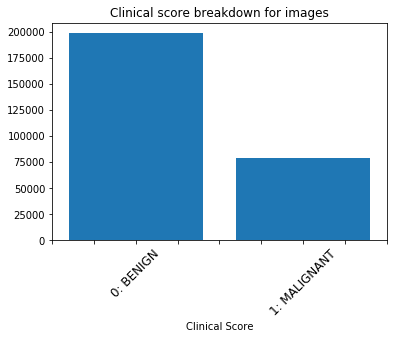

[198738  78785]


('C:/Users/74453/deep learning/final project/breast-histopathology-images/277524.png',
 'C:/Users/74453/deep learning/final project/breast-histopathology-images/3.png')

In [16]:
# Directory for the classification and the image files

CSV_PATH = Directory+'breast-histopathology-images/classification.csv'
DIR_PATH = Directory+'breast-histopathology-images/'
EXT = '.png'

file_paths_all = []
labels_all = []

# This reads all of the labels and save them to file path and labels
with open(CSV_PATH, newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    headers = next(csv_reader)
    for row in csv_reader:
        file_paths_all.append(join(DIR_PATH, str(row[1]) + EXT))
        labels_all.append(int(row[0]))

# To visualize how much data we have, we plot them in bar chart. The chart shows that we have two groups, 
# IDC positive and IDC negative

plt.bar(np.arange(2), np.bincount(labels_all))
plt.xlabel('Clinical Score')
plt.title('Clinical score breakdown for images')

plt.xticks(plt.xticks()[0], 
           ['','','0: BENIGN','','','', '1: MALIGNANT'],
           rotation=45,fontsize=12)
plt.show()
print(np.bincount(labels_all))

# labels_all = labels_all[0:100]
# file_paths_all = file_paths_all[0:100]

labels_all = np.array(labels_all, dtype=np.int)
file_paths_all[-1],file_paths_all[1]

***
<font color = "blue">

### 3. Add min_count number of file paths for each class to train_file_paths 

In [17]:
# This cell is enabled to select a small number of samples, it's only used for when we find the best epoch, 
# batch, and learning rate. n_samples is otherwise not used

# n_sample = 5000
n_sample = np.min(np.bincount(labels_all))
sample_file_paths = []
sample_labels = []

# Add min_count number of file paths for each class to train_file_paths, 
# The following loop balances the IDC positive and negative groups. Since we know that IDC positive is about 70%
# of the dataset. So we don't want that to overwhelm the training process.

for label in np.unique(labels_all):
    index = []
    for i in range(0,len(labels_all)):
        if labels_all[i] == label:
            index.append(i)
    
    ind = random.sample(index, n_sample)
    for j in ind:
        sample_file_paths.append(file_paths_all[j])
        sample_labels.append(labels_all[j])

len(sample_labels),len(sample_file_paths)
sample_labels = np.array(sample_labels)                
len(sample_labels)

157570

***
<font color = "blue">

### 4. Define function of creat dataset, fine turned AlexNet, simple net

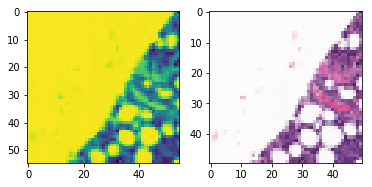

In [18]:
# This function reads the images from the image directory, then it decodes the image and finally resized the images.
# Finally, they are converted to Tensors, which can be used for training.

def create_dataset_fmr_images(file_paths):
    def _parse_function(filename):
        # Read images from file
        image_string = tf.read_file(filename)
        # Decode images into dense tensor
        image_decoded = tf.image.decode_png(image_string)
        # Resize the original images
        image_resized = tf.image.resize_images(image_decoded, [55, 55])
        return image_resized

    file_paths = tf.constant(file_paths)
    # create dataset by function we just defined
    dataset = tf.data.Dataset.from_tensor_slices((file_paths))
    dataset = dataset.map(_parse_function)

    return dataset

image_string = tf.read_file(file_paths_all[1])
        # Decode images into dense tensor
image_decoded = tf.image.decode_png(image_string)
        # Resize the original images
image_resized = tf.image.resize_images(image_decoded, [55, 55])

# The following shows the original and decoded image comparison. 
plt.figure()
plt.subplot(121)
plt.imshow(image_resized[:,:,0])
plt.subplot(122)
plt.imshow(image_decoded)

In [19]:
# This is our modified version of Alexnet, here we continued to use the base structure of Alexnet by preserving the 9
# layers of convolution, fully connected and classification layers. However, we added two additional fully connected
# layers right before the classification layer. And we change the features size that produced the optimal results. 

# During our fine tuning, we also change other parameters such as the stride, dropout rates and kernal size. However,
# they are proven to be not useful so we did not make the changes.
class Alexnet(tf.keras.Model):
    def __init__(self,classes):
        super(Alexnet,self).__init__()
        
        self.input_names = "None"
        # 1st Conv Layer for input image, with 32 filters, 11*11 kernel size and 4*4 strides
        # Followed by max pooling, 
        self.conv1 = Sequential()
#         self.conv1.add(ZeroPadding2D((5, 5), input_shape=(55, 55, 3)))
        self.conv1.add(Conv2D(filters=32,kernel_size=(11,11),strides=(4,4),padding='valid'))
        self.conv1.add(Activation('relu'))
        self.conv1.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
        self.conv1.add(BatchNormalization())
        
        #2nd Conv Layer
        self.conv2 = Sequential()
#         self.conv2.add(ZeroPadding2D(2, 2))
        self.conv2.add(Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same'))
        self.conv2.add(Activation('relu'))
        self.conv2.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
        self.conv2.add(BatchNormalization())
            
        #3rd Conv Layer    
        self.conv3 = Sequential()
#         self.conv3.add(ZeroPadding2D(1, 1))
        self.conv3.add(Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'))
        self.conv3.add(Activation('relu'))
        self.conv3.add(BatchNormalization())
        
        #4th Conv Layer
        self.conv4 = Sequential()
#         self.conv4.add(ZeroPadding2D(1, 1))
        self.conv4.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'))
        self.conv4.add(Activation('relu'))
        self.conv4.add(BatchNormalization())
            
        #5th Conv Layer    
        self.conv5 = Sequential()
#         self.conv5.add(ZeroPadding2D(1, 1))
        self.conv5.add(Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same'))
        self.conv5.add(Activation('relu'))
        self.conv5.add(BatchNormalization())
        self.conv5.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        
        #6th Layer
        self.fc = Sequential()
        self.fc.add(Flatten())
        
#       #7th 8th 9th and 10th Fully connected layers
        self.fc.add(Dense(2048))
        self.fc.add(Activation('relu'))
        self.fc.add(Dropout(0.4))
        
        self.fc.add(Dense(2048))
        self.fc.add(Activation('relu'))
        self.fc.add(Dropout(0.4))
        
        self.fc.add(Dense(512))
        self.fc.add(Activation('relu'))
        self.fc.add(Dropout(0.4))
        
        self.fc.add(Dense(128))
        self.fc.add(Activation('relu'))
        self.fc.add(Dropout(0.4))
        
        #11th Output Layer
        self.classification_layer = Sequential()
        self.classification_layer.add(Dense(classes))
    
    def call(self,x):
        #print(x.shape)
        conv1 = self.conv1(x)
        #print(conv1.shape)
        conv2 = self.conv2(conv1)
        #print(conv2.shape)
        conv3 = self.conv3(conv2)
        #print(conv3.shape)
        conv4 = self.conv4(conv3)
        #print(conv4.shape)
        conv5 = self.conv5(conv4)
        #print(conv5.shape)
        fc = self.fc(conv5)
        #print(fc.shape)
        out = self.classification_layer(fc)
        #print(out.shape)
        return out

In [20]:
# This is a simple net that we built to compare to the modified Alexnet. We want to see how much Alexnet can 
# outperform the simplenet, if it does. This assumes that deeper net has the advantage of better classification outcome
class net(tf.keras.Model):
    def __init__(self,classes):
        super(net,self).__init__()
        
        self.input_names = "None"
        # 1st Conv Layer for input image
        self.conv1 = Sequential()
        self.conv1.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',strides=(2,2)))

        
        #2nd Conv Layer
        # Followed by max pooling
        self.conv2 = Sequential()
        self.conv2.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
#         self.conv2.add(Activation('relu'))
        self.conv2.add(MaxPool2D(pool_size=(2, 2)))
#         self.conv2.add(BatchNormalization())
        self.conv2.add(Dropout(0.25))
            
        # 3rd flatten layer
        self.fc = Sequential()
        self.fc.add(Flatten())
        
        # 4th FC layer
        self.fc.add(Dense(128, activation='relu'))
        self.fc.add(Dropout(0.5))
        
        
        #5th Output Layer
        self.classification_layer = Sequential()
        self.classification_layer.add(Dense(classes))
    
    def call(self,x):
        #print(x.shape)
        conv1 = self.conv1(x)
        #print(conv1.shape)
        conv2 = self.conv2(conv1)
        #print(conv2.shape)
        fc = self.fc(conv2)
        #print(fc.shape)
        out = self.classification_layer(fc)
        #print(out.shape)
        return out

In [21]:
# Parameters for trian model, this has been adjusted multiple times to obtain the optimal combination of 
# parameters shown below
batch_size = 400        
n_epochs = 20       
learning_rate = 0.00003 

# Call AlexNet class to a variable
Alex = Alexnet(classes=2)#n_
# Define optimizer and its learning rate
optimizer = tf.train.AdamOptimizer(learning_rate)

In [24]:
def dataset(file_paths,labels,test_size):
    # Train test split by 0.2 ratio, reserve file pathes to find the misclassifiered images.
    x_train, x_test, y_train, y_test, train_filepaths, test_filepaths= train_test_split(file_paths, labels, file_paths, test_size=test_size, random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0)
 
    # Create dataset for train and test images.
    train_images_dataset = create_dataset_fmr_images(x_train)
    test_images_dataset = create_dataset_fmr_images(x_test)
    val_images_dataset = create_dataset_fmr_images(x_val)

    # Create dataset for train and test label
    train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
    test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
    val_labels_dataset = tf.data.Dataset.from_tensor_slices(y_val)

    print('Y_train_label.shape:',y_train.shape)
    print('Y_val_label.shape:',y_val.shape)
    print('Y_test_label.shape:',y_test.shape)


    n_train_samples = len(y_train)
    n_val_samples = len(y_val)
    n_test_samples = len(y_test)

    # prepare train dataset for images and labels zip together,slice it into batch size
    train_dataset = tf.data.Dataset.zip((train_images_dataset, train_labels_dataset))
    train_dataset = train_dataset.shuffle(buffer_size=n_train_samples).batch(batch_size)

    val_dataset = tf.data.Dataset.zip((val_images_dataset, val_labels_dataset))
    val_dataset = val_dataset.shuffle(buffer_size=n_val_samples).batch(batch_size)
    
#     val_dataset = tf.data.Dataset.zip((test_images_dataset, test_labels_dataset))
#     val_dataset = val_dataset.shuffle(buffer_size=n_test_samples).batch(batch_size)

    # prepare test dataset for images and labels zip together,slice it one by one to calculate accuracy
    test_dataset = tf.data.Dataset.zip((test_images_dataset, test_labels_dataset))
    test_dataset = test_dataset.batch(n_test_samples)
# random sort dataset and define batch size in it
    return train_dataset, val_dataset, test_dataset, y_train, y_test, test_filepaths

***
<font color = "blue">

# Calculation and Accuracy Evaluation
### 5. Train, plot loss function and calculate test accuracy

**a)** AlexNet

In [25]:
# This calls the dataset function we just defined
train_dataset, val_dataset, test_dataset, y_train, y_test_a, test_filepaths = dataset(sample_file_paths,sample_labels,0.2)

Y_train_label.shape: (94542,)
Y_val_label.shape: (31514,)
Y_test_label.shape: (31514,)


In [26]:
# This is a training step, it first creates loss history variables that are used to save the losses. Then it goes
# into each epoch and batch to activate the neural net, which returns a trained output and loss history

train_loss_history_a = []
validation_loss_history_a = []

with tf.device(device):
    for epoch in range(n_epochs):
        for batch, (images, labels) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                # Compute logits
                # use XceptionClassifier to train image
                logits = Alex(images) 
                # use softmax to caculate loss funciton
                xe_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

            # record loss function in every iteration
            train_loss_history_a.append(xe_loss.numpy())
            # Compute gradient and apply gradients to loss function, use optimizer to find the best parameters to reduce loss value.
            grads = tape.gradient(xe_loss, Alex.variables)
            optimizer.apply_gradients(zip(grads, Alex.variables),
                                  global_step=tf.train.get_or_create_global_step())
            if batch % 10 == 0:
                print('\rEpoch: {}, Batch: {}, Loss: {}'.format(epoch, batch, train_loss_history_a[-1]), end='')
            
        for batch, (images, labels) in enumerate(val_dataset):
            # caculate validation loss function, use model trained by train dataset.
            validation_logits = Alex(images)
            validation_loss =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=validation_logits))
            validation_loss_history_a.append(validation_loss.numpy())
            

Epoch: 19, Batch: 230, Loss: 0.42097723484039307

Text(0.5, 1.0, 'validation_loss_history')

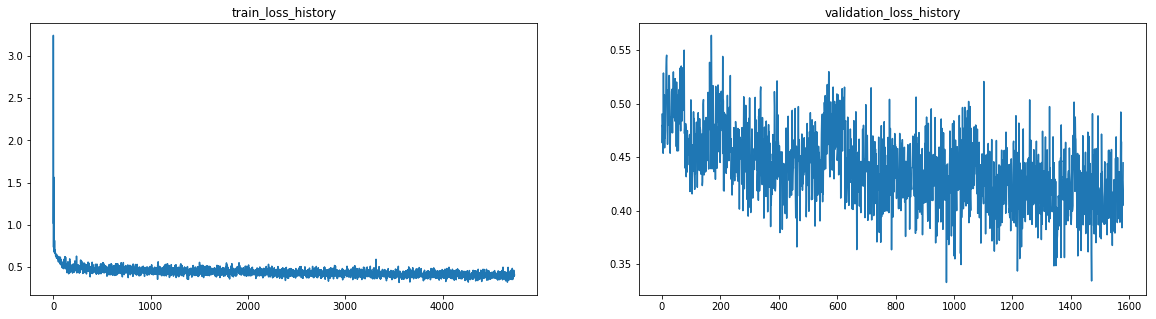

In [17]:
# This plots the loss history variables that we just calculated in the previous cell.
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(train_loss_history_a)
plt.title('train_loss_history')

plt.subplot(122)
plt.plot(validation_loss_history_a)
plt.title('validation_loss_history')

# plt.plot(train_loss_history)

 Compute test accuracy

In [12]:
# This cells runs the testing dataset via softmax function, by inputting the testing dataset to the 
# Alexnet and computing the accuracy.

for batch, (images, labels) in enumerate(test_dataset):
# Compute logits
    logits_a = Alex(images) 
    y_pred_a = tf.nn.softmax(logits_a).numpy()
    
    # Find the highest probability for prediction in 2 classes as predict label in images
# b = logits
pred_idxs_a = np.argmax(y_pred_a, axis=1)
#     print(y_pred_train)
#     Record the amount of correct prediction 
y_pred_final_a = 0
# This loop calculates the accuracy, by comparing each output to the true outcome.
for i in range(len(pred_idxs_a)):
     if pred_idxs_a[i] == y_test_a[i]: #and pred_idxs[i] == 0:
        y_pred_final_a += 1

    # Calculate the percentage of correct prediction
accuracy_test_a = y_pred_final_a * 1.0 / len(pred_idxs_a)
print('Test Acc in 2 class based on AlexNet:',accuracy_test_a)
 

Test Acc in 2 class based on AlexNet: 0.8057688646315924


Confusion matrix, without normalization
[[12956  2629]
 [ 3283 12646]]


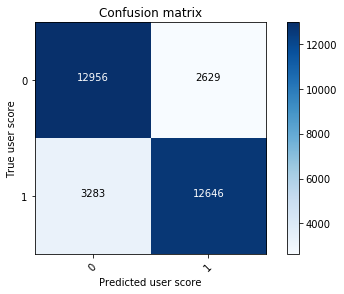

In [20]:
# This cell plots the confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True user score')
    plt.xlabel('Predicted user score')
    
    
cm=confusion_matrix(y_test_a, pred_idxs_a, labels=np.unique(y_test_a))
plot_confusion_matrix(cm,np.unique(y_test_a))

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test_a, pred_idxs_a, labels=np.unique(y_test_a))
print('F1 score is:',accuracy_test_a)
from sklearn.metrics import recall_score
recall_score(y_test_a, pred_idxs_a, average='macro')  

***
<font color = "blue">


### 6. Find misclassified image

In [27]:
# This cells runs the testing dataset via softmax function, by inputting the testing dataset to the 
# Alexnet and computing the accuracy.
# 删！！！！
for batch, (images, labels) in enumerate(test_dataset):
# Compute logits
    logits_a = Alex(images) 
    y_pred_a = tf.nn.softmax(logits_a).numpy()
    
    # Find the highest probability for prediction in 2 classes as predict label in images
# b = logits
pred_idxs_a = np.argmax(y_pred_a, axis=1)
#     print(y_pred_train)
#     Record the amount of correct prediction 
y_pred_final_a = 0
# This loop calculates the accuracy, by comparing each output to the true outcome.
for i in range(len(pred_idxs_a)):
     if pred_idxs_a[i] == y_test_a[i]: #and pred_idxs[i] == 0:
        y_pred_final_a += 1

    # Calculate the percentage of correct prediction
accuracy_test_a = y_pred_final_a * 1.0 / len(pred_idxs_a)
print('Test Acc in 2 class based on AlexNet:',accuracy_test_a)
 

Test Acc in 2 class based on AlexNet: 0.8096718918575871


false negative misclassifiede image: ['C:/Users/74453/deep learning/final project/breast-histopathology-images/161871.png', 'C:/Users/74453/deep learning/final project/breast-histopathology-images/184554.png', 'C:/Users/74453/deep learning/final project/breast-histopathology-images/272768.png', 'C:/Users/74453/deep learning/final project/breast-histopathology-images/86767.png', 'C:/Users/74453/deep learning/final project/breast-histopathology-images/60388.png']
false positive misclassifiede image: ['C:/Users/74453/deep learning/final project/breast-histopathology-images/157002.png', 'C:/Users/74453/deep learning/final project/breast-histopathology-images/275724.png', 'C:/Users/74453/deep learning/final project/breast-histopathology-images/25071.png', 'C:/Users/74453/deep learning/final project/breast-histopathology-images/233515.png', 'C:/Users/74453/deep learning/final project/breast-histopathology-images/33968.png']


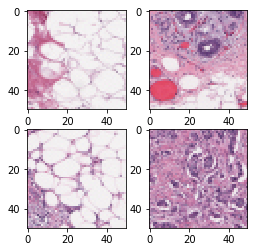

In [28]:
# This cell will separate images file paths by true positive, true ndegative, false positive and false negative. Then 
# plot 4 images as the order of confusion matrix that represent fn, fp, tn, tp.
misclassified_fp = []
misclassified_fn = []
right_tp = []
right_tn = []
# This loop will separate file paths for 4  categories
for i in range(0,len(pred_idxs_a)):
    if pred_idxs_a[i] ==1 and y_test_a[i] == 0:
        misclassified_fp.append(test_filepaths[i])
    if pred_idxs_a[i] ==0 and y_test_a[i] == 1:
        misclassified_fn.append(test_filepaths[i])
    if pred_idxs_a[i] ==1 and y_test_a[i] == 1:
        right_tp.append(test_filepaths[i])
    if pred_idxs_a[i] ==0 and y_test_a[i] == 0:
        right_tn.append(test_filepaths[i])

# Present misclassifier images file pathes
print('false negative misclassifiede image:', misclassified_fn[0:5])
print('false positive misclassifiede image:', misclassified_fp[0:5])
# get 4 images from fn, fp, tn, tp separately.
image_string_fn = tf.read_file(misclassified_fn[0])
image_decoded_fn = tf.image.decode_png(image_string_fn)

image_string_fp = tf.read_file(misclassified_fp[0])
image_decoded_fp = tf.image.decode_png(image_string_fp)

image_string_tn = tf.read_file(right_tn[0])
image_decoded_tn = tf.image.decode_png(image_string_tn)

image_string_tp = tf.read_file(right_tp[0])
image_decoded_tp = tf.image.decode_png(image_string_tp)

# plot 4 images as the order of confusion matrix
plt.figure(figsize=(4,4))
plt.subplot(221)
plt.imshow(image_decoded_tn)
plt.subplot(222)
plt.imshow(image_decoded_fp)
plt.subplot(223)
plt.imshow(image_decoded_fn)
plt.subplot(224)
plt.imshow(image_decoded_tp)

***
<font color = "blue">

###  7.Robust test, we wanted to train the model with different size of training dataset

### a) 10%

In [24]:
# Same as above, see comments above. This sets the test dataset to 10%
train_dataset1, val_dataset1, test_dataset1, y_train1, y_test_a1 = dataset(sample_file_paths,sample_labels,0.1)
Alex = Alexnet(classes=2)

Y_train_label.shape: (106359,)
Y_val_label.shape: (35454,)
Y_test_label.shape: (15757,)


In [25]:
# Same as above, see comments above

train_loss_history_a1 = []
validation_loss_history_a1 = []

with tf.device(device):
    for epoch in range(n_epochs):
        for batch, (images, labels) in enumerate(train_dataset1):

            with tf.GradientTape() as tape:
                # Compute logits
                # use XceptionClassifier to train image
                logits = Alex(images) 
                # use softmax to caculate loss funciton
                xe_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

            # record loss function in every iteration
            train_loss_history_a1.append(xe_loss.numpy())
            # Compute gradient and apply gradients to loss function, use optimizer to find the best parameters to reduce loss value.
            grads = tape.gradient(xe_loss, Alex.variables)
            optimizer.apply_gradients(zip(grads, Alex.variables),
                                  global_step=tf.train.get_or_create_global_step())
            if batch % 10 == 0:
                print('\rEpoch: {}, Batch: {}, Loss: {}'.format(epoch, batch, train_loss_history_a[-1]), end='')
            
        for batch, (images, labels) in enumerate(val_dataset1):
            # caculate validation loss function, use model trained by train dataset.
            validation_logits = Alex(images)
            validation_loss =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=validation_logits))
            validation_loss_history_a1.append(validation_loss.numpy())
            

Epoch: 19, Batch: 260, Loss: 0.4059898257255554

Text(0.5, 1.0, 'validation_loss_history')

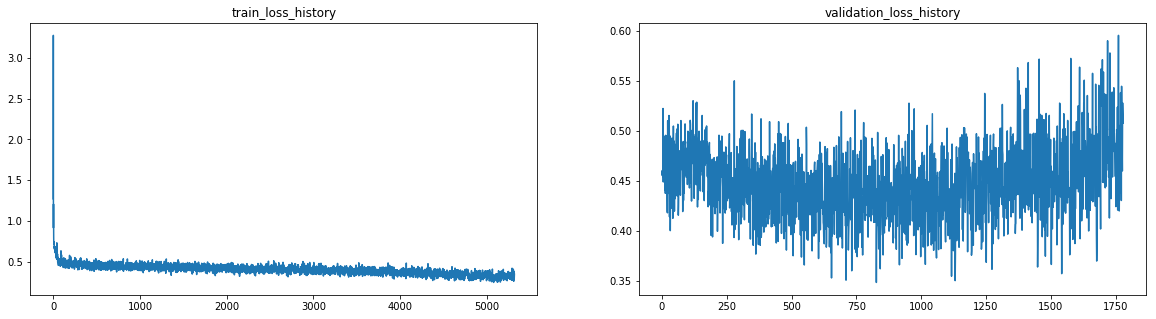

In [26]:
# Same as above, see comments above

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(train_loss_history_a1)
plt.title('train_loss_history')

plt.subplot(122)
plt.plot(validation_loss_history_a1)
plt.title('validation_loss_history')

In [27]:
# Same as above, see comments above

for batch, (images, labels) in enumerate(test_dataset1):
# Compute logits
    logits_a = Alex(images) 
    y_pred_a1 = tf.nn.softmax(logits_a).numpy()
    
    # Find the highest probability for prediction in 2 classes as predict label in images
pred_idxs_a1 = np.argmax(y_pred_a1, axis=1)
#     print(y_pred_train)
#     Record the amount of correct prediction 
y_pred_final_a1 = 0
for i in range(len(pred_idxs_a1)):
     if pred_idxs_a1[i] == y_test_a1[i]: #and pred_idxs[i] == 0:
        y_pred_final_a1 += 1

    # Calculate the percentage of correct prediction
accuracy_test_a1 = y_pred_final_a1 * 1.0 / len(pred_idxs_a1)
print('Test Acc in 2 class based on AlexNet, robust 10%:',accuracy_test_a1)

Test Acc in 2 class based on AlexNet, robust 10%: 0.7936155359522752


Confusion matrix, without normalization
[[6606 1147]
 [2105 5899]]


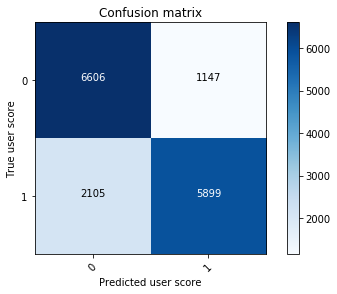

In [28]:
# Same as above, see comments above

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    import itertools
    """
     This function prints and plots the confusion matrix.
     Normalization can be applied by setting `normalize=True`.
     """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True user score')
    plt.xlabel('Predicted user score')
    
    
cm1=confusion_matrix(y_test_a1, pred_idxs_a1, labels=np.unique(y_test_a1))
plot_confusion_matrix(cm1,np.unique(y_test_a1))

### b) 30%

In [29]:
# Same as above, see comments above. This sets the test dataset to 30%
train_dataset3, val_dataset3, test_dataset3, y_train3, y_test_a3 = dataset(sample_file_paths,sample_labels,0.3)
# reset model
Alex = Alexnet(classes=2)

Y_train_label.shape: (82724,)
Y_val_label.shape: (27575,)
Y_test_label.shape: (47271,)


In [30]:
# Same as above, see comments above

train_loss_history_a3 = []
validation_loss_history_a3 = []

with tf.device(device):
    for epoch in range(n_epochs):
        for batch, (images, labels) in enumerate(train_dataset3):

            with tf.GradientTape() as tape:
                # Compute logits
                # use XceptionClassifier to train image
                logits = Alex(images) 
                # use softmax to caculate loss funciton
                xe_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

            # record loss function in every iteration
            train_loss_history_a3.append(xe_loss.numpy())
            # Compute gradient and apply gradients to loss function, use optimizer to find the best parameters to reduce loss value.
            grads = tape.gradient(xe_loss, Alex.variables)
            optimizer.apply_gradients(zip(grads, Alex.variables),
                                  global_step=tf.train.get_or_create_global_step())
            if batch % 10 == 0:
                print('\rEpoch: {}, Batch: {}, Loss: {}'.format(epoch, batch, train_loss_history_a[-1]), end='')
            
        for batch, (images, labels) in enumerate(val_dataset3):
            # caculate validation loss function, use model trained by train dataset.
            validation_logits = Alex(images)
            validation_loss =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=validation_logits))
            validation_loss_history_a3.append(validation_loss.numpy())
            

Epoch: 19, Batch: 200, Loss: 0.4059898257255554

Text(0.5, 1.0, 'validation_loss_history')

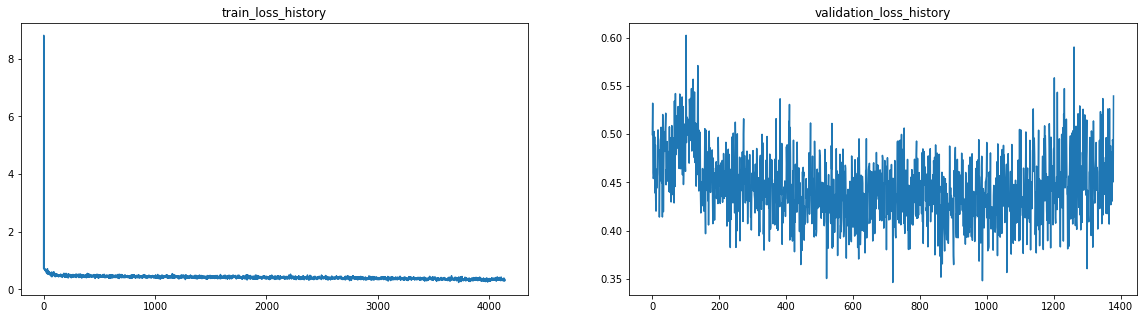

In [31]:
# Same as above, see comments above

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(train_loss_history_a3)
plt.title('train_loss_history')

plt.subplot(122)
plt.plot(validation_loss_history_a3)
plt.title('validation_loss_history')

In [32]:
# Same as above, see comments above

for batch, (images, labels) in enumerate(test_dataset3):
# Compute logits
    logits_a = Alex(images) 
    y_pred_a3 = tf.nn.softmax(logits_a).numpy()
    
    # Find the highest probability for prediction in 2 classes as predict label in images
pred_idxs_a3 = np.argmax(y_pred_a3, axis=1)
#     print(y_pred_train)
#     Record the amount of correct prediction 
y_pred_final_a3 = 0
for i in range(len(pred_idxs_a3)):
     if pred_idxs_a3[i] == y_test_a3[i]: #and pred_idxs[i] == 0:
        y_pred_final_a3 += 1

    # Calculate the percentage of correct prediction
accuracy_test_a3 = y_pred_final_a3 * 1.0 / len(pred_idxs_a3)
print('Test Acc in 2 class based on AlexNet, rubust 30%:',accuracy_test_a3)

Test Acc in 2 class based on AlexNet, rubust 30%: 0.7985868714433797


Confusion matrix, without normalization
[[19099  4213]
 [ 5308 18651]]


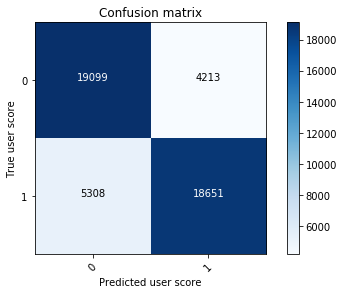

In [33]:
# Same as above, see comments above

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    import itertools
    """
     This function prints and plots the confusion matrix.
     Normalization can be applied by setting `normalize=True`.
     """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True user score')
    plt.xlabel('Predicted user score')
    
    
cm3=confusion_matrix(y_test_a3, pred_idxs_a3, labels=np.unique(y_test_a3))
plot_confusion_matrix(cm3,np.unique(y_test_a3))

***
<font color = "blue">

# Metrics Analysis
### 8. ROC curve and AUC area

Auc value in 20% robust: 0.8885287764261417
Auc value in 10% robust: 0.8678821784773808
Auc value in 30% robust: 0.8720094840081272


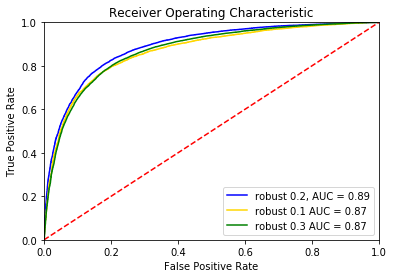

In [34]:
# This pulls out all the results we have just calculated and produces the metrics testing. By using the sklearn.metrics
# library and the ROC and AUC functions. All ROC curves for different cases are plotting under the same graph

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_a, y_pred_a[:,1])
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test_a1, y_pred_a1[:,1])
fpr3, tpr3, threshold3 = metrics.roc_curve(y_test_a3, y_pred_a3[:,1])

# Calculate AUC area and print
roc_auc = metrics.auc(fpr, tpr)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc3 = metrics.auc(fpr3, tpr3)
print('Auc value in 20% robust:', roc_auc)
print('Auc value in 10% robust:', roc_auc1)
print('Auc value in 30% robust:', roc_auc3)
# method I: plt

# Plot ROC curve for test dataset
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'A, AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, 'b', label = 'robust 0.2, AUC = %0.2f' % roc_auc)
plt.plot(fpr1, tpr1, 'gold', label = 'robust 0.1 AUC = %0.2f' % roc_auc1)
plt.plot(fpr3, tpr3, 'g', label = 'robust 0.3 AUC = %0.2f' % roc_auc3)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
# from ggplot import *
# df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
# ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

***
<font color = "blue">

# Simple Model
### 9. Simple model calculation

In [10]:
# This cell is where we call the simple net and use the simple network to do the training and classification. 
nnet = net(classes=2)

In [11]:
# Same as above, see above comments
train_loss_historys = []
validation_loss_historys = []


with tf.device(device):
    for epoch in range(n_epochs_n):
        for batch, (images, labels) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                # Compute logits
                # use XceptionClassifier to train image
                logits = nnet(images) 
                # use softmax to caculate loss funciton
                xe_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

            # record loss function in every iteration
            train_loss_historys.append(xe_loss.numpy())
            # Compute gradient and apply gradients to loss function, use optimizer to find the best parameters to reduce loss value.
            grads = tape.gradient(xe_loss, nnet.variables)
            optimizer.apply_gradients(zip(grads, nnet.variables),
                                  global_step=tf.train.get_or_create_global_step())
            if batch % 10 == 0:
                print('\rEpoch: {}, Batch: {}, Loss: {}'.format(epoch, batch, train_loss_historys[-1]), end='')
            
        for batch, (images, labels) in enumerate(val_dataset):
            # caculate validation loss function, use model trained by train dataset.
            validation_logits = nnet(images)
            validation_loss =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=validation_logits))
            validation_loss_historys.append(validation_loss.numpy())

Epoch: 19, Batch: 10, Loss: 1.4593362808227542


Text(0.5, 1.0, 'validation_loss_history')

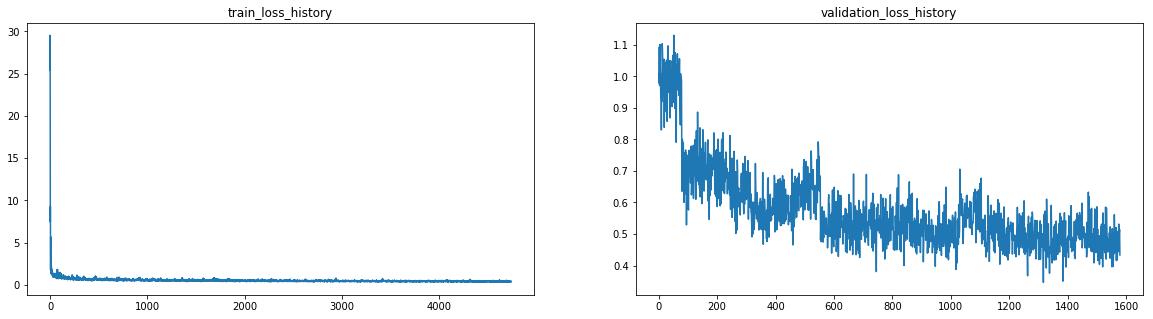

In [ ]:
# Same as above, see above comments

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(train_loss_historys)
plt.title('train_loss_history')

plt.subplot(122)
plt.plot(validation_loss_historys)
plt.title('validation_loss_history')

# plt.plot(train_loss_history)

In [17]:
# Same as above, see above comments

for batch, (images, labels) in enumerate(test_dataset):
# Compute logits
    logits = nnet(images) 
    y_pred_s = tf.nn.softmax(logits).numpy()
    
    # Find the highest probability for prediction in 2 classes as predict label in images
b = logits
pred_idxss = np.argmax(y_pred_s, axis=1)
#     print(y_pred_train)
#     Record the amount of correct prediction 
y_pred_finals = 0
for i in range(len(pred_idxss)):
     if pred_idxss[i] == y_test_a[i]: #and pred_idxs[i] == 0:
        y_pred_finals += 1

    # Calculate the percentage of correct prediction
accuracy_trains = y_pred_finals * 1.0 / len(pred_idxss)
print('Train Acc in 2 class:',accuracy_trains)
 

Train Acc in 2 class: 0.747


***
<font color = "blue">

### 10.ROC curve for simple model

Auc value in simple net: 0.8044023339360867


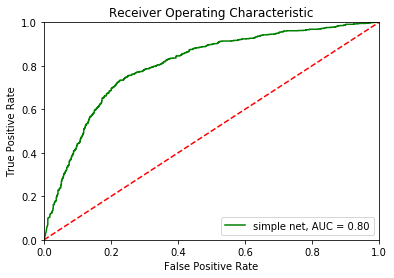

In [18]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]

fprs, tprs, thresholds = metrics.roc_curve(y_test_a, y_pred_s[:,1])

# Calculate AUC area and print

roc_aucs = metrics.auc(fprs, tprs)
# print('Auc value in simple net:', roc_auca)
print('Auc value in simple net:', roc_aucs)
# method I: plt

# Plot ROC curve for test dataset
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')

plt.plot(fprs, tprs, 'g', label = 'simple net, AUC = %0.2f' % roc_aucs)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
# from ggplot import *
# df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
# ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')